# Build The Image-Based Customer Segmentation Model
1. Dataset Creation
2. Data Creation
3. GAN Model Architecture
4. Training GAN
5. Image Segmentation and Customer Clustering
6. Evaluation and Segmentation

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


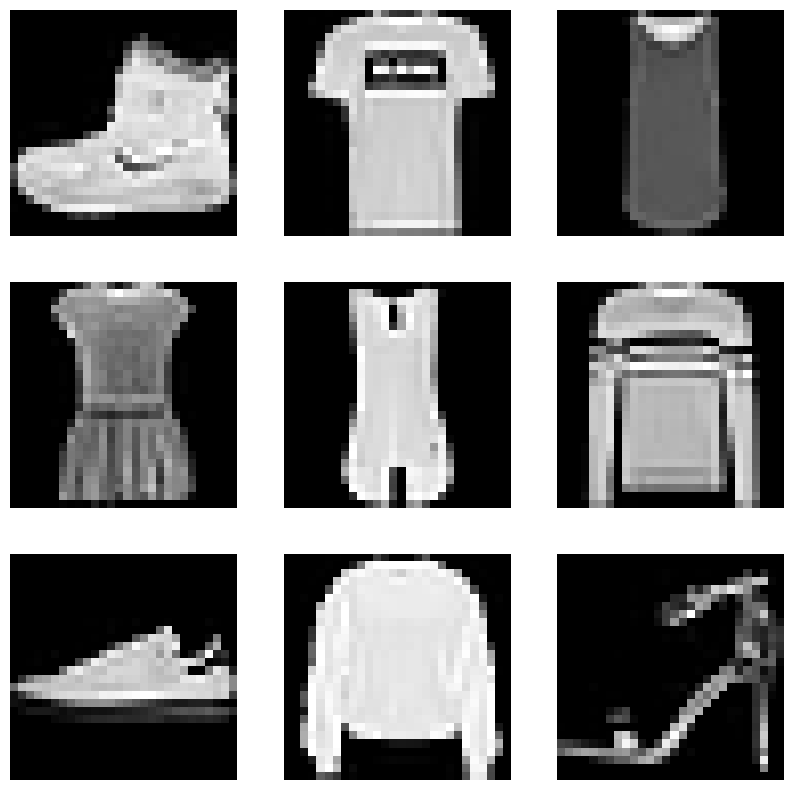

In [1]:
# Dataset Creation

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load fashion dataset (replace it with customer images dataset if you have one)
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Rescale the data to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Visualizing some sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
plt.show()

In [2]:
# Data Preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Normalize and reshape the images to (28, 28, 1) for grayscale
X_train = np.expand_dims(X_train, axis=-1)  # Add the channel dimension
X_test = np.expand_dims(X_test, axis=-1)

# Check shape
print(X_train.shape)

(60000, 28, 28, 1)


## GAN Model Architecture


*   Generator: Generates fake images based on random noise.
*   Discriminator: Classifies images as real or fake.



In [3]:
# Generator Model
def build_generator(z_dim):
    model = Sequential()
    model.add(layers.Dense(256, input_dim=z_dim))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(np.prod((28, 28, 1)), activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

# Define random noise dimension (latent space)
z_dim = 100

# Build the generator
generator = build_generator(z_dim)
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         803,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [4]:
# Discriminator Model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid output for binary classification

    return model

# Image shape
img_shape = (28, 28, 1)

# Build the discriminator
discriminator = build_discriminator(img_shape)
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Compiling the GAN
from tensorflow.keras.optimizers import Adam

def build_gan(generator, discriminator):
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

# Compile the Discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Compile the GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [7]:
# training the GAN
import os
import matplotlib.pyplot as plt
import numpy as np

# Function to save generated images
def save_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, (examples, z_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_image_epoch_{epoch}.png")
    plt.close()

# Training GAN
epochs = 100
batch_size = 64
half_batch = batch_size // 2

# Training loop
for epoch in range(epochs):
    # Train Discriminator with real images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_images = X_train[idx]
    labels_real = np.ones((half_batch, 1))

    # Train Discriminator with fake images
    noise = np.random.normal(0, 1, (half_batch, z_dim))
    fake_images = generator.predict(noise)
    labels_fake = np.zeros((half_batch, 1))

    # Train Discriminator (real + fake images)
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(fake_images, labels_fake)

    # Train Generator to fool Discriminator
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    labels_gan = np.ones((batch_size, 1))  # We want the generator to trick the discriminator
    g_loss = gan.train_on_batch(noise, labels_gan)

    # Print progress
    if epoch % 1000 == 0:
        print(f"{epoch} [D loss real: {d_loss_real[0]} | D loss fake: {d_loss_fake[0]}] [G loss: {g_loss}]")
        save_generated_images(epoch, generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0 [D loss real: 4.460721492767334 | D loss fake: 4.461498260498047] [G loss: 0.003828379325568676]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


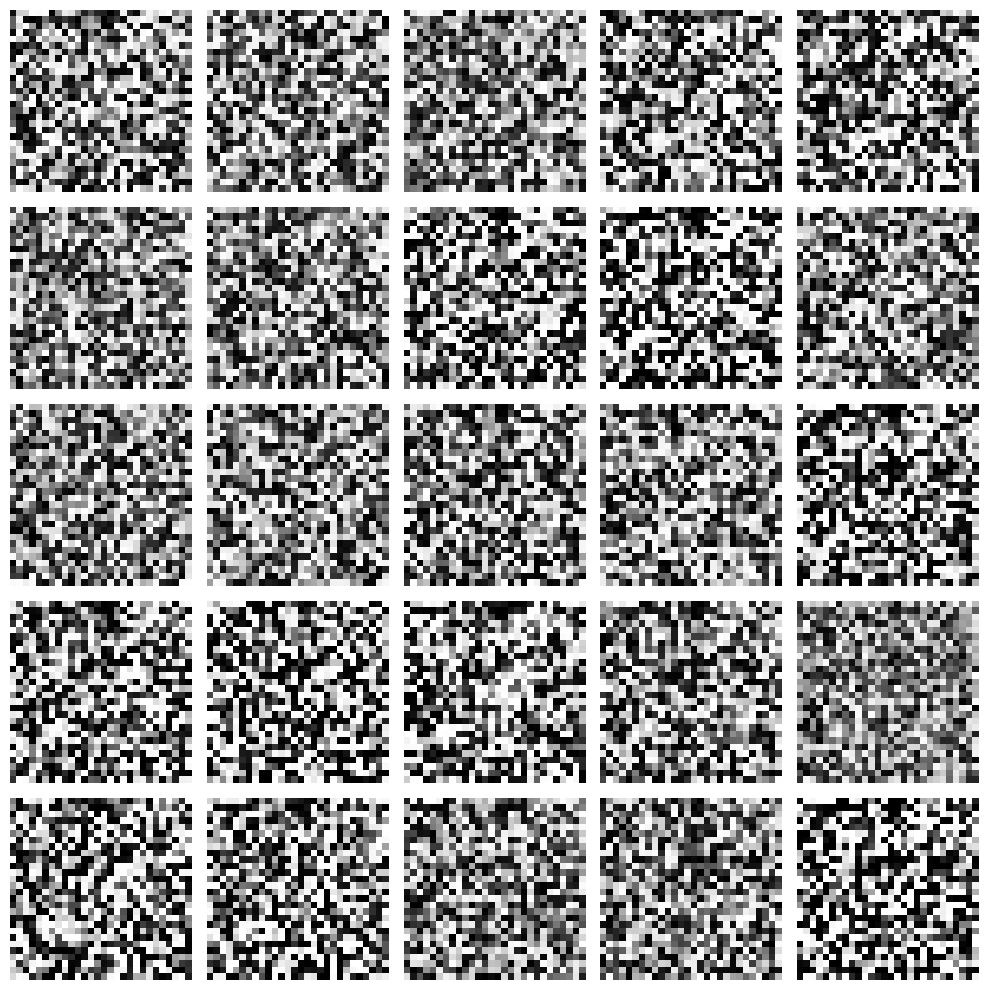

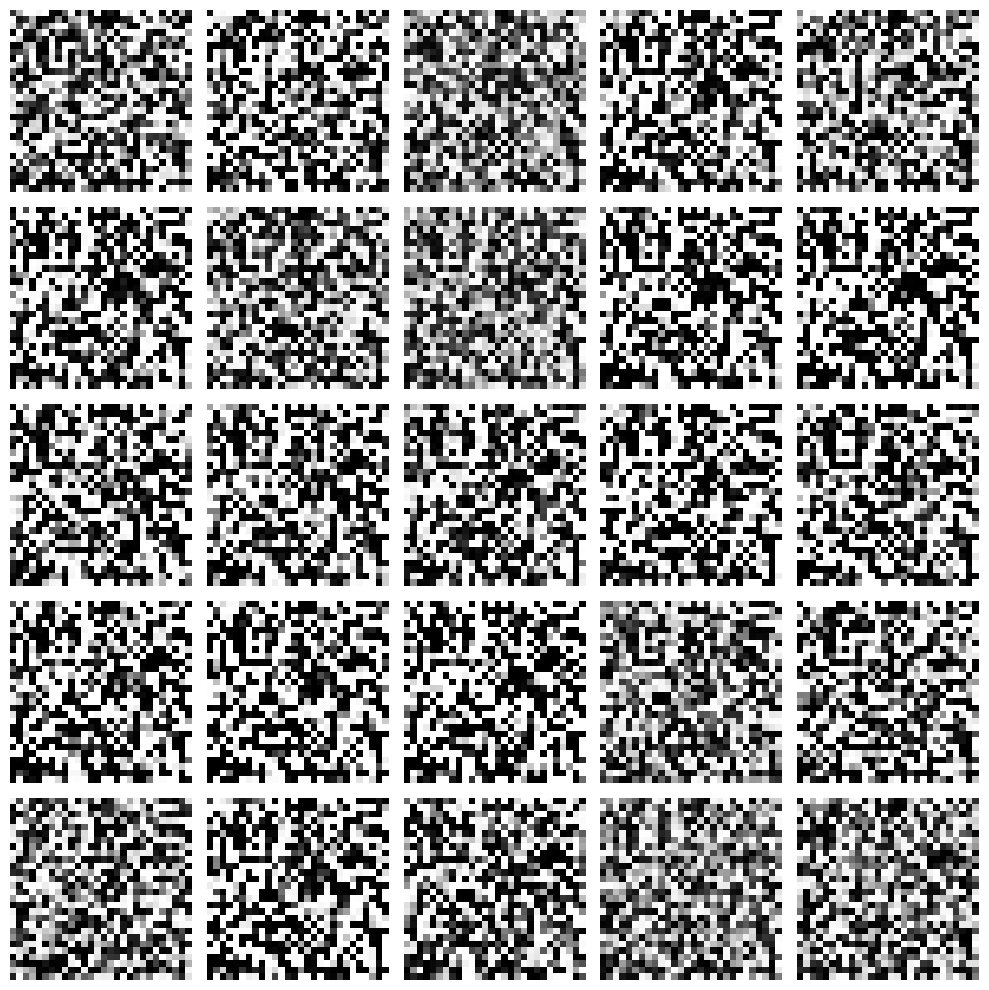

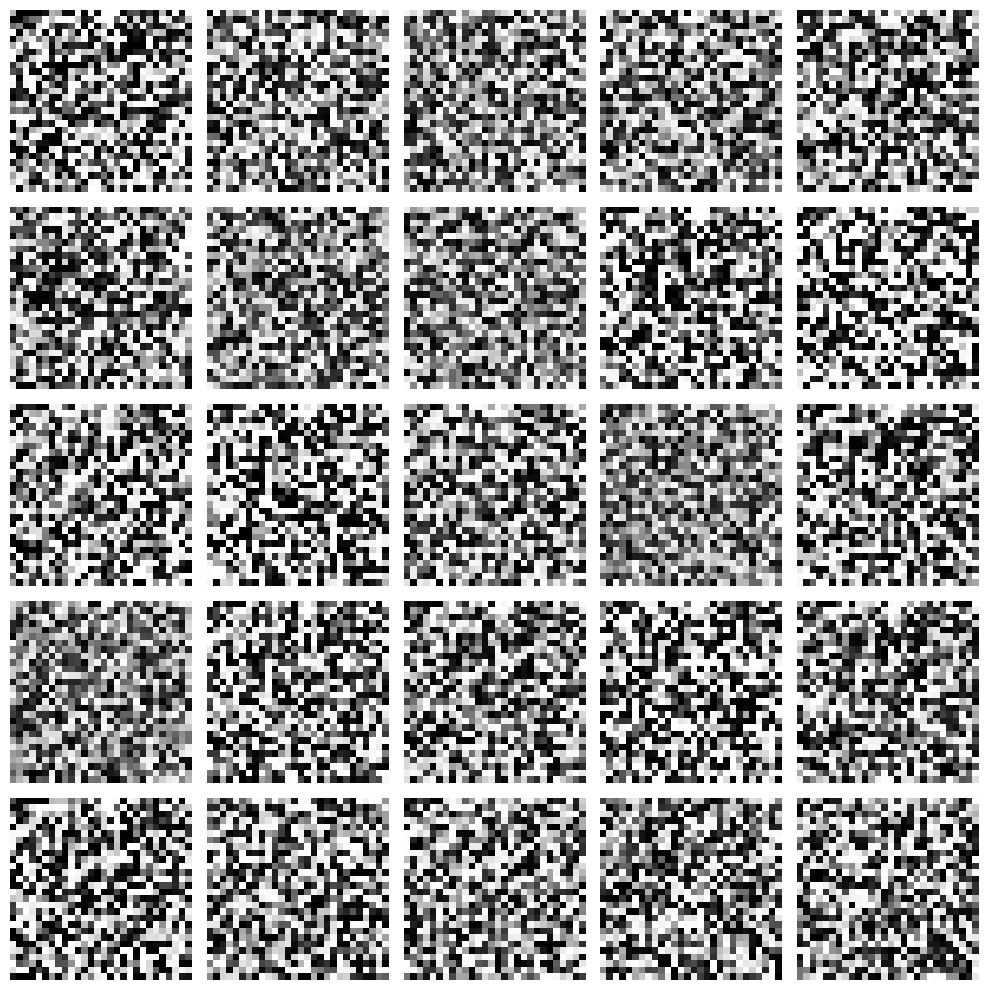

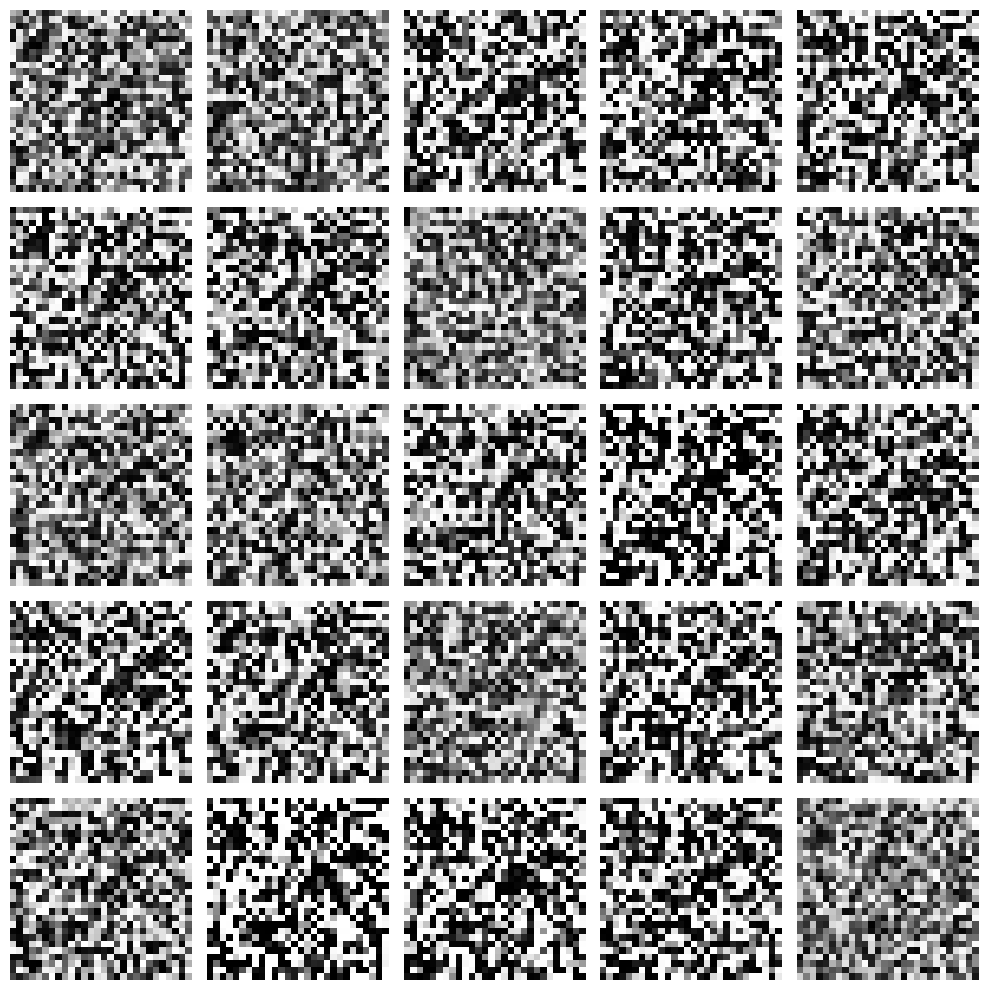

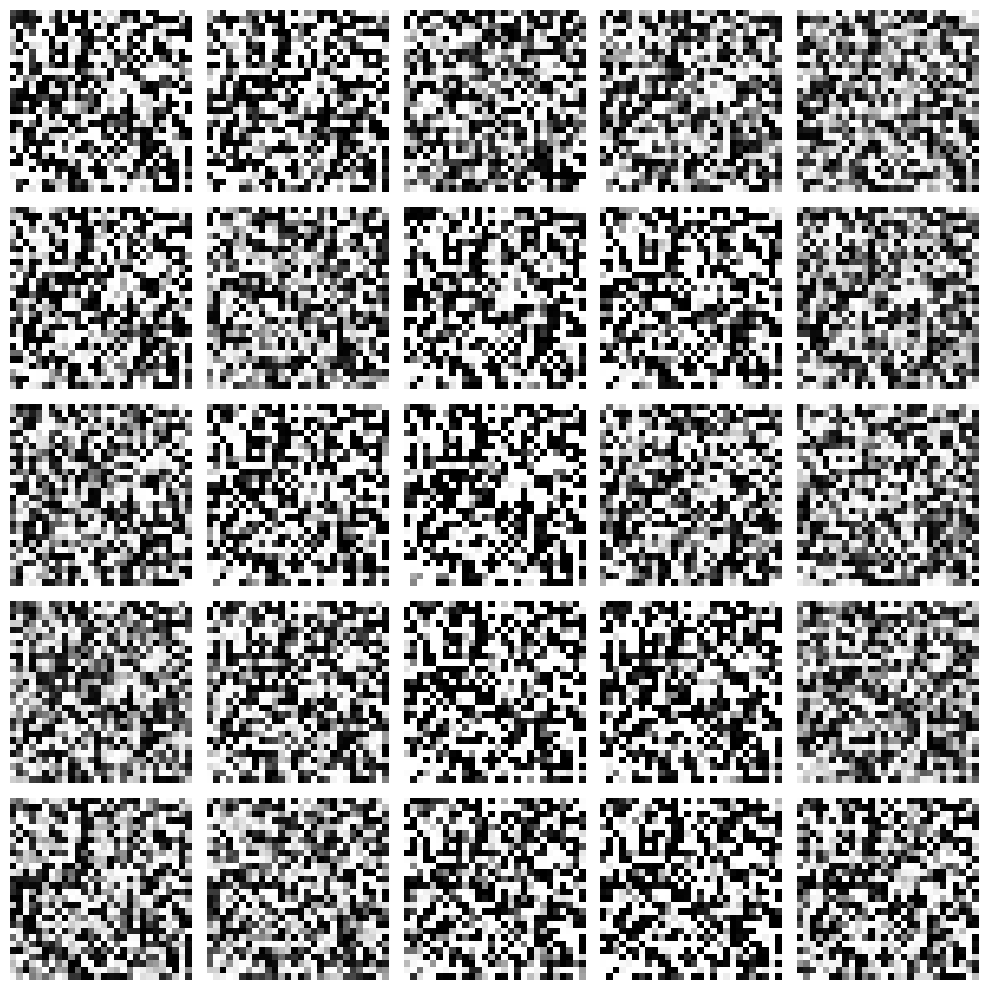

In [8]:
# Image Segmentation and Customer Clustering
from sklearn.cluster import KMeans

# Generate images
noise = np.random.normal(0, 1, (1000, z_dim))
generated_images = generator.predict(noise)

# Flatten the images for clustering
flat_images = generated_images.reshape(generated_images.shape[0], -1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(flat_images)

# Display the clustering results
for i in range(5):
    cluster_images = generated_images[kmeans.labels_ == i]
    plt.figure(figsize=(10, 10))
    for j in range(min(25, len(cluster_images))):
        plt.subplot(5, 5, j+1)
        plt.imshow(cluster_images[j], cmap="gray")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
# Evaluation and Refinement
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(flat_images, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.16078908741474152
